# The 2D Tree-Grid method & application to HJB equation for option pricing under the 2-factor uncertain volatility model

- Implementation of 2D Tree-Grid method with boundary conditions possibly dependent on t (time) and but constant in spacedirection tangent to boundary. To compute boundary condition data from previous boundary condition can be used Domain has to be rectangular. Problem coefficients have to be time-independent.

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import TreeGrid_module as TG

## 2D Tree-Grid  method implementation

- The main function (2D Tree-Grid method with time-independent coefficients):

In [2]:
def TreeGrid2D(X,Y,T,model,TCBC,BC_args, SpaceStepCoef):
    # INPUT: X,Y -sorted state-spaces, T -sorted time-axis, model -object including functions for drift, volatility,
    # reward, and discount, TCBC -object including functions for terminal and boundary conditions, BC_args -data needed 
    # for constructions of boundary conditions. SpaceStepCoef - multiplicator of max(cx,dy) in definition of h.
    # feasible BCs: time-dependent, but constant in direction tagential to the boundary
    M=T.shape[0]
    Nx=X.shape[0]    
    Ny=Y.shape[0]
    Controls=model.controls
    QN=Controls.shape[0]
    ext=model.extrem
    dt=T[1]-T[0]
    # reserving place for computed transition probabilities, transition indices and discount factor:
    [Po,PXl,PXr,PYl,PYr,PXYplus,PXYminus,IndXo,IndXl,IndXr,IndYo,IndYl,IndYr, Discount]\
    =[[0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN, [0]*QN]
    # computing transition probabilites, indices and discount factors for all possible controls:
    for k in range(QN):
        # computation with larger stencil -h dependent on dt,dx,dy:
        [Po[k],PXl[k],PXr[k],PYl[k],PYr[k],PXYplus[k],PXYminus[k],IndXo[k],IndXl[k],IndXr[k],IndYo[k],IndYl[k],IndYr[k],\
        CvEx]=approximate_flow_2D(X,Y,dt,Controls[k],model,SpaceStepCoef)
        # computing discount factor:
        Discount[k]=1-dt*model.discount(X,Y,Controls[k])     
    # starting with terminal condition:
    V=TCBC.TC(X,Y)
    # reserving place for new-time-layer-candidates:
    W=np.zeros([QN,Nx,Ny])
    #creating lambda function for minimization/maximization (dependent on extrem):
    if ext=='min':
        optimize= lambda W:np.amin(W, axis=0)
    else:
        optimize= lambda W:np.amax(W, axis=0) 
    # consecutively computing V in all time layers: 
    for t in range(M-1):
        # computing new time-layer candidate for all possible controls:
        for k in range(QN):
            # 1.-4. rows:flows from inner nodes to inner nodes, boundary nodes, or beyond the boundary, where the solution
            # is supposed the same value as in the nearest boundary node
            # 5. row: solution in boundary nodes
            W[k]=Discount[k]*(Po[k]*V[IndXo[k],IndYo[k]] + PXl[k]*V[IndXl[k], IndYo[k]] + PXr[k]*V[IndXr[k], IndYo[k]]\
            + PYl[k]*V[IndXo[k], IndYl[k]] + PYr[k]*V[IndXo[k], IndYr[k]]\
            + PXYplus[k]*(V[IndXl[k],IndYl[k]]+V[IndXr[k],IndYr[k]])\
            + PXYminus[k]*(V[IndXl[k],IndYr[k]]+V[IndXr[k],IndYl[k]]))\
            + TCBC.BC(t+1,BC_args)
        # searching optimum in new time layer:
        V=optimize(W)
    # saving Flags -informations about solution (e.g.: for debbuging)
    Flags=0
    # returning solution V in the last (here initial) time layer and Flags:
    return V, Flags

- the approximate flow function, for computing (mainly) the transition probabilities for each state:

In [3]:
def approximate_flow_2D(X,Y,dt,q,model,SpaceStepCoef):    
    # INPUT: X,Y -sorted state-spaces, dt -current time-step, q -current control, 
    # model-object including functions for drift, volatility, reward, and discount
    # SpaceStepCoef multiplicator of max(cx,dy) in definition of h (~square of stencil size parameter)
    Nx=X.shape[0]
    Ny=Y.shape[0]
    Y_inner, X_inner=np.meshgrid(Y[1:Ny-1], X[1:Nx-1])

    # computing volatility, drift and correlataion:
    vol_x=model.volatility_x(X_inner,Y_inner,q)
    vol_y=model.volatility_y(X_inner,Y_inner,q)
    drf_x=model.drift_x(X_inner,Y_inner,q)
    drf_y=model.drift_y(X_inner,Y_inner,q)
    corr=model.correlation(X_inner,Y_inner,q)
    dx=np.max(X[1:Nx]-X[0:Nx-1])
    dy=np.max(Y[1:Ny]-Y[0:Ny-1])

    # computing parameter h (step) which will determinate stencil size
    h=np.maximum(dt,SpaceStepCoef*np.maximum(dx,dy))
    b=h/dt
    
    # computing variance, expected value of new state-old state:
    E_x=drf_x*dt
    E_y=drf_y*dt
    artVar_x=0.5*(abs(E_x)*np.sqrt(4*b**2*E_x**2+16*b*dx*abs(E_x)) - (2*b-2)*E_x**2 + 4*dx*abs(E_x))
    artVar_y=0.5*(abs(E_y)*np.sqrt(4*b**2*E_y**2+16*b*dy*abs(E_y)) - (2*b-2)*E_y**2 + 4*dy*abs(E_y))
    Var_x=np.maximum(np.maximum(vol_x**2*dt,artVar_x),E_x**2)
    Var_y=np.maximum(np.maximum(vol_y**2*dt,artVar_y),E_y**2)
    W_x=Var_x+E_x**2
    W_y=Var_y+E_y**2

    # Case of non-negative expectation E_x
    # computing exact left and right flow from each non-boundary (inner) state (X direction):
    X_inner_left_flow1=X_inner-np.sqrt(2*b*W_x)
    X_inner_right_flow1=X_inner+np.sqrt(2*b*W_x)
    
    # searching indices of the nearest left grid-point  to left flow and nearest right grid point to right flow:
    # (specially treated are cells with zero flow, to not divide by zero later when computing trans. probabilities)
    # (if the left flow lands beyond left boundary index=-1, if right lands beyond right boundary index=Nx)
    Xindex_inner_left1=np.searchsorted(X,X_inner_left_flow1,side='right') -1 - (X_inner_left_flow1==X_inner)
    Xindex_inner_right1=np.searchsorted(X,X_inner_right_flow1,side='left') + (X_inner_right_flow1==X_inner)
    
    # computing states from X-grid corresponding to left and right flow indices: 
    # (special treatment needed for unvalid indices -1, N; here state corresponds to exact flow, not to some grid state)
    X_inner_left1=X[np.maximum(Xindex_inner_left1,0)]
    X_inner_left1[Xindex_inner_left1==-1]=X_inner_left_flow1[Xindex_inner_left1==-1]
    X_inner_right1=X[np.minimum(Xindex_inner_right1,Nx-1)]
    X_inner_right1[Xindex_inner_right1==Nx]=X_inner_right_flow1[Xindex_inner_right1==Nx]
    
    # Case of positive expectation E_x
    X_inner_left_flow2=np.minimum(X_inner_left_flow1,2*X_inner-X_inner_right1)
    X_inner_right_flow2=np.maximum(X_inner_right_flow1,2*X_inner-X_inner_left1)

    Xindex_inner_left2=np.searchsorted(X,X_inner_left_flow2,side='right') -1 - (X_inner_left_flow2==X_inner)
    Xindex_inner_right2=np.searchsorted(X,X_inner_right_flow2,side='left') + (X_inner_right_flow2==X_inner)
    X_inner_left2=X[np.maximum(Xindex_inner_left2,0)]
    X_inner_left2[Xindex_inner_left2==-1]=X_inner_left_flow2[Xindex_inner_left2==-1]
    X_inner_right2=X[np.minimum(Xindex_inner_right2,Nx-1)]
    X_inner_right2[Xindex_inner_right2==Nx]=X_inner_right_flow2[Xindex_inner_right2==Nx]
    
    # Combining case of non-negative E_x and of negative E_x
    Xindex_inner_left=np.array(Xindex_inner_left1)
    Xindex_inner_left[E_x<0]=Xindex_inner_left2[E_x<0]
    X_inner_left=np.array(X_inner_left1)
    X_inner_left[E_x<0]=X_inner_left2[E_x<0]
    Xindex_inner_right=np.array(Xindex_inner_right1)
    Xindex_inner_right[E_x<0]=Xindex_inner_right2[E_x<0]
    X_inner_right=np.array(X_inner_right1)
    X_inner_right[E_x<0]=X_inner_right2[E_x<0]

    # Repeating everything in the Y-direction
    Y_inner_left_flow1=Y_inner-np.sqrt(2*b*W_y)
    Y_inner_right_flow1=Y_inner+np.sqrt(2*b*W_y)

    Yindex_inner_left1=np.searchsorted(Y,Y_inner_left_flow1,side='right') -1 - (Y_inner_left_flow1==Y_inner)
    Yindex_inner_right1=np.searchsorted(Y,Y_inner_right_flow1,side='left') + (Y_inner_right_flow1==Y_inner)
    Y_inner_left1=Y[np.maximum(Yindex_inner_left1,0)]
    Y_inner_left1[Yindex_inner_left1==-1]=Y_inner_left_flow1[Yindex_inner_left1==-1]
    Y_inner_right1=Y[np.minimum(Yindex_inner_right1,Ny-1)]
    Y_inner_right1[Yindex_inner_right1==Ny]=Y_inner_right_flow1[Yindex_inner_right1==Ny]

    Y_inner_left_flow2=np.minimum(Y_inner_left_flow1,2*Y_inner-Y_inner_right1)
    Y_inner_right_flow2=np.maximum(Y_inner_right_flow1,2*Y_inner-Y_inner_left1)

    Yindex_inner_left2=np.searchsorted(Y,Y_inner_left_flow2,side='right') -1 - (Y_inner_left_flow2==Y_inner)
    Yindex_inner_right2=np.searchsorted(Y,Y_inner_right_flow2,side='left') + (Y_inner_right_flow2==Y_inner)
    Y_inner_left2=Y[np.maximum(Yindex_inner_left2,0)]
    Y_inner_left2[Yindex_inner_left2==-1]=Y_inner_left_flow2[Yindex_inner_left2==-1]
    Y_inner_right2=Y[np.minimum(Yindex_inner_right2,Ny-1)]
    Y_inner_right2[Yindex_inner_right2==Ny]=Y_inner_right_flow2[Yindex_inner_right2==Ny]

    Yindex_inner_left=np.array(Yindex_inner_left1)
    Yindex_inner_left[E_y<0]=Yindex_inner_left2[E_y<0]
    Y_inner_left=np.array(Y_inner_left1)
    Y_inner_left[E_y<0]=Y_inner_left2[E_y<0]
    Yindex_inner_right=np.array(Yindex_inner_right1)
    Yindex_inner_right[E_y<0]=Yindex_inner_right2[E_y<0]
    Y_inner_right=np.array(Y_inner_right1)
    Y_inner_right[E_y<0]=Y_inner_right2[E_y<0]

    # computing Deltas -distances between left/right state and initial (or middle) state:
    Delta_right_X=X_inner_right-X_inner
    Delta_left_X=X_inner-X_inner_left
    Delta_right_Y=Y_inner_right-Y_inner
    Delta_left_Y=Y_inner-Y_inner_left
    
    # computing values that the |W_xy|/Delta_c should not exceed
    ppx_right=(W_x+E_x*Delta_left_X)/(Delta_right_X**2+Delta_left_X*Delta_right_X)
    ppx_left=(W_x-E_x*Delta_right_X)/(Delta_left_X**2+Delta_left_X*Delta_right_X)
    ppy_right=(W_y+E_y*Delta_left_Y)/(Delta_right_Y**2+Delta_left_Y*Delta_right_Y)
    ppy_left=(W_y-E_y*Delta_right_Y)/(Delta_left_Y**2+Delta_left_Y*Delta_right_Y)

    # computing new covariance in such manner, that the correlation coefficient remains same 
    # also ofter redefining Variance (through possible addition of artifitial diffusion)
    cov=np.sqrt(Var_x*Var_y)*corr/dt
    # computing Delta_c
    Delta_c=Delta_right_X*Delta_right_Y + Delta_left_X*Delta_left_Y
    Delta_c[cov*dt+E_x*E_y<0]=(Delta_right_X*Delta_left_Y + Delta_left_X*Delta_right_Y)[cov*dt+E_x*E_y<0]
    
    # Computing new covariance in such manner that PXl,PXr,PYl,PYr will be non-negative
    C_xy=np.minimum(np.minimum(np.minimum(ppx_right,ppx_left),np.minimum(ppy_right,ppy_left))*Delta_c,abs(cov*dt+E_x*E_y))
    Cov=C_xy-E_x*E_y
    Cov[cov*dt+E_x*E_y<0]=(-C_xy-E_x*E_y)[cov*dt+E_x*E_y<0]
    W_xy=Cov+E_x*E_y
    
    # Computing transition probabilites. 
    # Probabilities on the boundary are zero, the boundary condition is added separately
    Po=np.zeros([Nx,Ny])
    Po[1:Nx-1,1:Ny-1]=1 - W_y/(Delta_left_Y*Delta_right_Y) - W_x/(Delta_left_X*Delta_right_X)\
    +E_y*(Delta_right_Y-Delta_left_Y)/(Delta_left_Y*Delta_right_Y)\
    +E_x*(Delta_right_X-Delta_left_X)/(Delta_left_X*Delta_right_X) + 2*abs(W_xy)/Delta_c

    PXr=np.zeros([Nx,Ny])
    PXr[1:Nx-1,1:Ny-1]=ppx_right-abs(W_xy)/Delta_c
    PXl=np.zeros([Nx,Ny])
    PXl[1:Nx-1,1:Ny-1]=ppx_left-abs(W_xy)/Delta_c
    PYr=np.zeros([Nx,Ny])
    PYr[1:Nx-1,1:Ny-1]=ppy_right-abs(W_xy)/Delta_c
    PYl=np.zeros([Nx,Ny])
    PYl[1:Nx-1,1:Ny-1]=ppy_left-abs(W_xy)/Delta_c

    pxyplus=np.zeros([Nx-2,Ny-2])
    pxyplus[W_xy>=0]=(abs(W_xy)/Delta_c)[W_xy>=0]
    PXYplus=np.zeros([Nx,Ny])
    PXYplus[1:Nx-1,1:Ny-1]=pxyplus
    pxyminus=np.zeros([Nx-2,Ny-2])
    pxyminus[W_xy<0]=(abs(W_xy)/Delta_c)[W_xy<0]
    PXYminus=np.zeros([Nx,Ny])
    PXYminus[1:Nx-1,1:Ny-1]=pxyminus
    
    # rewriting unvalid indices (-1,Nx) by (0,Nx-1) to avoid out-of-scope-error:
    # these rewrited indices represent flows boeyond the boundaries, and rewriting them with boundary indices 0, Nx-1 is
    # valid if the solution behind the boundary is approximately constant in the direction tangential to the boundary.
    IndXl=np.zeros([Nx,Ny]).astype(int)
    IndXl[1:Nx-1,1:Ny-1]=np.maximum(Xindex_inner_left,0)
    IndXr=np.zeros([Nx,Ny]).astype(int)
    IndXr[1:Nx-1,1:Ny-1]=np.minimum(Xindex_inner_right,Nx-1)
    
    # Doing the same in Y-direction
    IndYl=np.zeros([Nx,Ny]).astype(int)
    IndYl[1:Nx-1,1:Ny-1]=np.maximum(Yindex_inner_left,0)
    IndYr=np.zeros([Nx,Ny]).astype(int)
    IndYr[1:Nx-1,1:Ny-1]=np.minimum(Yindex_inner_right,Ny-1)
    IndYo,IndXo=np.meshgrid(np.arange(0,Ny), np.arange(0,Nx))
    
    # saving information in which nodes the covariance was modelled exactly. (if it was not the case in some node,
    # and we used h dependent only on dt, we have to use h dependent also on dx dy.)
    CovExact=np.zeros([Nx,Ny]).astype(bool)
    CovExact[1:Nx-1,1:Ny-1]=(Cov==cov*dt)
    #returning transition probabilities indices and information of covariance approximation:    
    return (Po,PXl,PXr,PYl,PYr,PXYplus,PXYminus, IndXo, IndXl, IndXr, IndYo, IndYl, IndYr, CovExact)

## Application to 2-factor uncertain volatility model
### Classes defining model and terminal&boundary functions for the 2D problem:
- Class defining drifts, volatilities, correlation reward and discount functions for the model (SCP=stochastic control problem):

In [4]:
class SCP_uncertain_volatility_2D:
    def drift_x(self,x,y,q):
        return self.interest*x
    def drift_y(self,x,y,q):
        return self.interest*y
    def volatility_x(self,x,y,q):
        return x*q[0]
    def volatility_y(self,x,y,q):
        return y*q[1]
    def covariance(self,x,y,q):
        return x*y*q[0]*q[1]*q[2]
    def correlation(self,x,y,q):
        return q[2]
    def reward(self,x,y,q):
        return 0
    def discount(self,x,y,q):
        return self.interest
    def __init__(self,r=0.05,sigma_x_min=0.3,sigma_x_max=0.5,sigma_y_min=0.3,sigma_y_max=0.5,ro_min=0.3,ro_max=0.5,\
                 no_controls_x=3, no_controls_y=3, extrem='max'):
        self.interest=r
        Q1=np.linspace(sigma_x_min,sigma_x_max,no_controls_x)
        Q2=np.linspace(sigma_y_min,sigma_y_max,no_controls_y)
        Q3=np.array([ro_min,ro_max])
        Contr=[]
        for l in Q3:
            for j in Q1:
                Contr.append([j,Q2[0],l])
                Contr.append([j,Q2[-1],l])
            for k in Q2[1:-1]:
                Contr.append([Q1[0],k,l])
                Contr.append([Q1[-1],k,l])
        self.controls=np.array(Contr)
        self.extrem=extrem    

- Class defining the terminal and boundary conditions for the problem:

In [5]:
class TCBC_butterfly_2D:
    def TC(self,X,Y):
        V0=np.zeros([X.shape[0],Y.shape[0]])
        for j in range(X.shape[0]):
            for k in range(Y.shape[0]):
                if self.typ=='max':
                    Sm=np.maximum(X[j],Y[k])
                else:
                    Sm=np.minimum(X[j],Y[k])
                V0[j,k]=np.maximum(Sm-self.K1,0)+np.maximum(Sm-self.K2,0)-2*np.maximum(Sm-(self.K1+self.K2)/2,0)
        return V0
    def BC(self,t_index, BC_args):
        if self.typ=='max':
            BC_down=BC_args[0]
            BC_left=BC_args[1]
            boundary=np.zeros([BC_down.shape[1],BC_left.shape[1]])            
            boundary[0,:]=BC_left[t_index,:]
            boundary[:,0]=BC_down[t_index,:]
        else:
            boundary=0
        return boundary
    def __init__(self,K1=34,K2=46,typ='max'):
        self.K1=K1
        self.K2=K2
        self.typ=typ

### Classes defining model and terminal&boundary functions for the 1D problems arising on the boundaries:
- Class defining drifts, volatilities, correlation reward and discount functions for the 1D model describing behaviour on the (lower and left )boundaries. The upper and right boundary is set to 0. (SCP=stochastic control problem):

In [6]:
class SCP_uncertain_volatility:
    def drift(self,x,q):
        return self.interest*x
    def volatility(self,x,q):
        return x*q
    def reward(self,x,q):
        return 0
    def discount(self,x,q):
        return self.interest
    def __init__(self, r=0.05, sigma_min=0.3, sigma_max=0.5, extrem='max'):
        self.interest=r
        self.controls=np.array([sigma_min, sigma_max])
        self.extrem=extrem

- Class defining the terminal and boundary conditions for the 1D problem arising on the (lower and left) boundaries:

In [7]:
class TCBC_butterfly:
    def TC(self,X):
        V0=np.zeros(X.shape[0])
        for k in range(X.shape[0]):
                V0[k]=np.maximum(X[k]-self.K1,0)+np.maximum(X[k]-self.K2,0)-2*np.maximum(X[k]-(self.K1+self.K2)/2,0)
        return V0
    def BCL(self,x,t):
        return 0
    def BCR(self,x,t):
        return 0
    def __init__(self,K1=34,K2=46):
        self.K1=K1
        self.K2=K2

### Pricing the butterfly spread on maximum of two assets under uncertain volatility model with the 2D Tree-Grid method 
- computing the results:

In [8]:
# creating rough grid:
X1=np.arange(0,144+8,8)
X2=np.arange(0,80+4,4)
X3=np.arange(30,50+2,2)
X=np.sort(np.unique(np.concatenate((X1,X2,X3))))
T=np.arange(0,0.25+0.01,0.01)
# refining grid:
no_refinements=1
for k in range(no_refinements):
    XX=(X[1:X.shape[0]]+X[0:X.shape[0]-1])/2
    X=np.sort(np.unique(np.concatenate((X,XX))))
    TT=(T[1:T.shape[0]]+T[0:T.shape[0]-1])/2
    T=np.sort(np.unique(np.concatenate((T,TT))))
# defining Y grid (as a copy of X-grid): 
Y=np.array(X)

# creting model and boundary objects for the 2D problem and for the 1D problems on the left and lower boundary 
maxmodel=SCP_uncertain_volatility_2D()
maxmodel_for_BC=SCP_uncertain_volatility()
minmodel=SCP_uncertain_volatility_2D(extrem='min')
minmodel_for_BC=SCP_uncertain_volatility(extrem='min')
TCBC=TCBC_butterfly_2D()
TCBC_for_BC=TCBC_butterfly()

# searching worst case scenario price (HJB with maximization):
#    -solving 1D problems on the left and lower boundary:
solution_down=TG.TreeGridFull(X,T,maxmodel_for_BC,TCBC_for_BC)
solution_left=TG.TreeGridFull(Y,T,maxmodel_for_BC,TCBC_for_BC)
#    -saving solutions of 1D problems as argument for boundary conditions for 2D problem 
BC_args=[solution_down,solution_left]
#    -solving the original 2D problem:
Vmax, Flags=TreeGrid2D(X,Y,T,maxmodel,TCBC,BC_args,1/400)

# searching best case scenario price (HJB with minimization) (in the same way):
solution_down=TG.TreeGridFull(X,T,minmodel_for_BC,TCBC_for_BC)
solution_left=TG.TreeGridFull(Y,T,minmodel_for_BC,TCBC_for_BC)
BC_args=[solution_down,solution_left]
Vmin, Flags=TreeGrid2D(X,Y,T,minmodel,TCBC,BC_args,1/400)

# creating meshgrid for identification of the solution in a particular point:
Yy, Xx = np.meshgrid(Y, X)
#prinitng solution for X=40$, Y=40$
print('Butterfly spread price for X=40$, Y=40$ is worth in best case',Vmin[(Xx==40)*(Yy==40)][0],'$ and in worst case',\
      Vmax[(Xx==40)*(Yy==40)][0],'$.')

Butterfly spread price for X=40$, Y=40$ is worth in best case 0.954594684046 $ and in worst case 2.65677830724 $.


- plotting terminal condition (butterfly payoff diagram) and the option price with respect to asset prices: worst and best case scenarios:

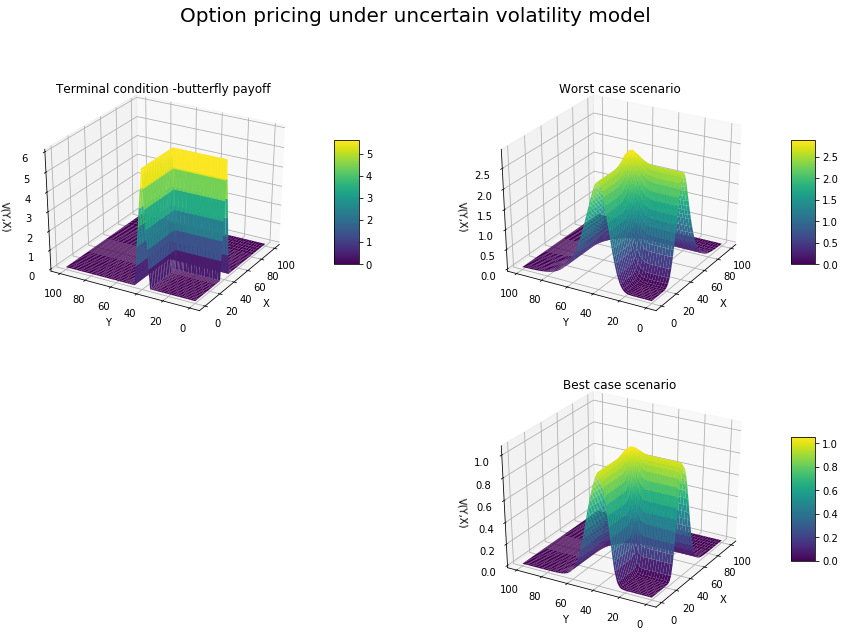

In [9]:
Vmaxm=Vmax[0:np.sum(X<=100),0:np.sum(Y<=100)]
Vminm=Vmin[0:np.sum(X<=100),0:np.sum(Y<=100)]
V0=TCBC.TC(X,Y)
V0m=V0[0:np.sum(X<=100),0:np.sum(Y<=100)]
# creating meshgrid
Ym, Xm = np.meshgrid(Y[Y<=100], X[X<=100])

fig1 = plt.figure()
fig1.suptitle('Option pricing under uncertain volatility model',fontsize=20)
figsz=fig1.get_size_inches() # returns size of figure
fig1.set_size_inches(2.5*figsz[0],2.5*figsz[1]) 

pl1 = fig1.add_subplot(2,2,1,projection='3d')
surf = pl1.plot_surface(Xm, Ym, V0m, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig1.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('X')
pl1.set_ylabel('Y')
pl1.set_zlabel('V(Y,X)')
pl1.set_title('Terminal condition -butterfly payoff')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=azm+270)

pl1 = fig1.add_subplot(2,2,2,projection='3d')
surf = pl1.plot_surface(Xm, Ym, Vmaxm, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig1.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('X')
pl1.set_ylabel('Y')
pl1.set_zlabel('V(Y,X)')
pl1.set_title('Worst case scenario')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=azm+270)

pl1 = fig1.add_subplot(2,2,4,projection='3d')
surf = pl1.plot_surface(Xm, Ym, Vminm, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
fig1.colorbar(surf, shrink=0.5, aspect=5)
pl1.set_xlabel('X')
pl1.set_ylabel('Y')
pl1.set_zlabel('V(Y,X)')
pl1.set_title('Best case scenario')
elv, azm = pl1.elev, pl1.azim
pl1.view_init(elev=elv,azim=azm+270)

plt.show()